# Article figures for Asilomar SSA wave transformation

In [258]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import statsmodels.api as sm
from datetime import datetime as DT
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import salem
import utm
from pyproj import Proj
# Interactive plots
%matplotlib widget 
from roxsi_pyfuns import stats as rps
from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import turbulence as rpt
from roxsi_pyfuns import plotting as rppl

# Paths, files
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
pc_root = '/home/mikapm/ROXSI/Asilomar2022/SmallScaleArray'
# Figure output
outdir = os.path.join(pc_root, 'Article_figures')
# Bathymetry
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy_updated_50cm.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))
# Signature 1000 ADCP data
sig_root = os.path.join(rootdir, 'Signatures', 'Level1')
# Vector ADCP data
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')

# Start/end dates/times of experiment period
t0 = pd.Timestamp('2022-06-27 00:00') # Start date
t1 = pd.Timestamp('2022-07-21 00:00') # End date

Figure 1: Study site & bathymetry

In [159]:
# Plot w/ google satellite image following example from
# https://salem.readthedocs.io/en/stable/auto_examples/plot_googlestatic.html
fn_fig1 = os.path.join(outdir, 'fig1.png')
if not os.path.isfile(fn_fig1):
    utm_zone = 10 # Standard UTM zone number (northern hemisphere)
    FFX = 0 # Fudge Factor in x (East)
    FFY = -5 # Fudge Factor in y (North) -5 seems to work well

    # UTM coordinates of box corners and middle of rock from GPS 
    # measurements of safety sausage from boat. Errors in these are 
    # up to several meters due to GPS error and currents
    IN = [594490.19 + FFX, 4053805.82 + FFY] # Inshore North
    ON = [594478.45 + FFX, 4053815.67 + FFY] # Offshore North
    OS = [594470.48 + FFX, 4053808.93 + FFY] # Offshore South
    IS = [594477.74 + FFX, 4053799.02 + FFY] # Inshore South
    PEAK = [594475.87 + FFX, 4053806.77 + FFY] # Middle of rock

    # UTM coordinates of box corners and middle of rock, 
    # approximated by eye based on estimated positions relative 
    # to bathymetric features 
    IS_est = np.array([0.594476227663551, 4.053794712172897]) * 1e6
    OS_est = np.array([0.594470871355140, 4.053806078995327]) * 1e6
    IN_est = np.array([0.594488330467290, 4.053799782266355]) * 1e6
    ON_est = np.array([0.594479294252336, 4.053812580163552]) * 1e6

    # Calculate line segment lengths
    ON_IN = np.sqrt((ON[0]-IN[0])**2 + (ON[1]-IN[1])**2)
    IN_IS = np.sqrt((IN[0]-IS[0])**2 + (IN[1]-IS[1])**2)
    IS_OS = np.sqrt((IS[0]-OS[0])**2 + (IS[1]-OS[1])**2)
    OS_ON = np.sqrt((OS[0]-ON[0])**2 + (OS[1]-ON[1])**2)

    ON_IN_est = np.sqrt((ON_est[0]-IN_est[0])**2 + 
                        (ON_est[1]-IN_est[1])**2)
    IN_IS_est = np.sqrt((IN_est[0]-IS_est[0])**2 + 
                        (IN_est[1]-IS_est[1])**2)
    IS_OS_est = np.sqrt((IS_est[0]-OS_est[0])**2 + 
                        (IS_est[1]-OS_est[1])**2)
    OS_ON_est = np.sqrt((OS_est[0]-ON_est[0])**2 + 
                        (OS_est[1]-ON_est[1])**2)

    # Select subset of bathymetry data in region around small-scale 
    # array. Make a box that lines up with UTM of subsurface buoys 
    # with a buffer region around it. 
    BUFFERREGION = 10  # size of buffer region beyond coords of subsurface buys
    eastingMin = min(np.array([IN[0],ON[0],OS[0],IS[0]]) - BUFFERREGION)
    eastingMax = max(np.array([IN[0],ON[0],OS[0],IS[0]]) + BUFFERREGION)
    northingMin = min(np.array([IN[1],ON[1],OS[1],IS[1]]) - BUFFERREGION)
    northingMax = max(np.array([IN[1],ON[1],OS[1],IS[1]]) + BUFFERREGION)
    vmin = -8.0
    vmax = -3.5
    
    # Initialize figure
    # fig, ax = plt.subplots(figsize=(7,7), constrained_layout=True)

    fig, axes = plt.subplots(figsize=(15,7.5), ncols=2, nrows=2, height_ratios=[4,1])
    gs = axes[0, 0].get_gridspec()
    # remove the underlying axes
    for ax in axes[:, 0]:
        ax.remove()
    axbig = fig.add_subplot(gs[:, 0])

    # Define background boundaries for plot (P)
    buffer = 140 # Buffer distance (m)
    latMinP, lonMinP = utm.to_latlon(eastingMin-buffer+120, northingMin-buffer, 
                                     zone_number=utm_zone, northern=True)
    latMaxP, lonMaxP = utm.to_latlon(eastingMax+buffer+120, northingMax+buffer, 
                                     zone_number=utm_zone, northern=True)

    # If you need to do a lot of maps you might want
    # to use an API key and set it here with key='YOUR_API_KEY'
    g = salem.GoogleVisibleMap(x=[lonMinP, lonMaxP], y=[latMinP, latMaxP],
                               scale=2,  # scale is for more details
                               maptype='satellite',
                               )
    # The google static image is a standard rgb image
    ggl_img = g.get_vardata()

    # Make a map of the same size as the image (no country borders)
    sm = salem.Map(g.grid, factor=2, countries=False)
    sm.set_shapefile()  # add the glacier outlines
    sm.set_rgb(ggl_img)  # add the background rgb image
    sm.set_scale_bar(location=(0.13, 0.12), color='white')  # add scale
    sm.set_lonlat_contours(max_nticks=6)
    sm.visualize(ax=axes[0,1])  # plot it

    # Mark SSA location with star
    proj_utm = Proj(proj='utm', zone=utm_zone, ellps='WGS84', preserve_units=False)
    em = (eastingMax + eastingMin) / 2
    nm = (northingMax + northingMin) / 2
    latm, lonm = utm.to_latlon(em, nm, zone_number=utm_zone, northern=True)
    # Convert to UTM
    xpu, ypu = proj_utm(lonm, latm)
    # Convert UTM coordinates to google image projection
    xp, yp = sm.grid.transform(xpu, ypu, crs=proj_utm)
    axes[0,1].scatter(xp, yp, marker='*', c='salmon', edgecolors='k', s=350)

    # Annotate (b)
    axes[0,1].annotate('(b)', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=18, 
                color='white')

#     # Show/save plot
#     plt.tight_layout()
#     # plt.show()
#     if not os.path.isfile(fn_fig1a):
#         plt.savefig(fn_fig1a, bbox_inches='tight', dpi=450)
#     plt.close()

# # Bathymetry plot with mean transect line
# fn_fig1b = os.path.join(outdir, 'bathymetry_zoom.png')
# if not os.path.isfile(fn_fig1b):
#     fig, axes = plt.subplots(figsize=(7,7), nrows=2, height_ratios=[4,1], sharex=True)
    vmin = -8 
    vmax = -4
    # Set zoom in region
    x0 = dsb.C3.attrs['x_loc'].round() # C3 mooring location in the middle
    y0 = dsb.C3.attrs['y_loc'].round()
    xmin = x0 - 15
    xmax = x0 + 15
    ymin = y0 - 15
    ymax = y0 + 15
    bathy_zoom = dsb.z_msl.sel(x=slice(xmin, xmax), y=slice(ymin, ymax)).copy()
    im = bathy_zoom.plot.pcolormesh(ax=axbig, add_colorbar=False, vmin=vmin, vmax=vmax,
                                    cmap=cmocean.cm.deep_r)
    # Colorbar on right
    cax = axbig.inset_axes([1.01, 0.00, 0.05, 1.0], transform=axbig.transAxes)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_title(r'  $z$ [m]')
    # Take 1D transect to plot on bottom row
    ymin_t = y0 - 3
    ymax_t = y0 + 3
    transect = dsb.z_msl.sel(x=slice(xmin, xmax), y=slice(ymin_t, ymax_t)).mean(dim='y')
    # Mark boundaries of transect
    axbig.axhline(ymin_t, ls='--', lw=2, color='white')
    axbig.axhline(ymax_t, ls='--', lw=2, color='white')
    # Mark and annotate moorings
    x_c1, y_c1 = (dsb.C1.attrs['x_loc'], dsb.C1.attrs['y_loc']) # C1 (Sig)
    x_c6, y_c6 = (dsb.C6.attrs['x_loc'], dsb.C6.attrs['y_loc']) # C6 (Sig)
    x_c2, y_c2 = (dsb.C2.attrs['x_loc'], dsb.C2.attrs['y_loc']) # C2 (Vec)
    x_c5, y_c5 = (dsb.C5.attrs['x_loc'], dsb.C5.attrs['y_loc']) # C5 (Vec)
    x_l1, y_l1 = (dsb.L1.attrs['x_loc'], dsb.L1.attrs['y_loc']) # L1 (Vec)
    x_l5, y_l5 = (dsb.L5.attrs['x_loc'], dsb.L5.attrs['y_loc']) # L1 (Vec)
    axbig.scatter(x0, y0, marker='s', color='darkviolet', s=250, edgecolors='k') # C3
    axbig.text(x0-2.5, y0+1.25, s='SM/VM', color='darkviolet', fontsize=18)
    axbig.scatter(x_c1, y_c1, marker='o', color='tomato', s=250, edgecolors='k') 
    axbig.text(x_c1-1.25, y_c1+1, s='SO', color='tomato', fontsize=18)
    axbig.scatter(x_c6, y_c6, marker='o', color='tomato', s=250, edgecolors='k') 
    axbig.text(x_c6-0.75, y_c6+1, s='SI', color='tomato', fontsize=18)
    axbig.scatter(x_c2, y_c2, marker='^', color='royalblue', s=250, edgecolors='k') 
    axbig.text(x_c2-1, y_c2+1, s='VO', color='blue', fontsize=18)
    axbig.scatter(x_c5, y_c5, marker='^', color='royalblue', s=250, edgecolors='k') 
    axbig.text(x_c5-0.5, y_c5-2.25, s='VI', color='blue', fontsize=18)
    axbig.scatter(x_l1, y_l1, marker='^', color='royalblue', s=250, edgecolors='k') 
    axbig.text(x_l1-0.7, y_l1-2.25, s='VS', color='royalblue', fontsize=18)
    axbig.scatter(x_l5, y_l5, marker='^', color='royalblue', s=250, edgecolors='k') 
    axbig.text(x_l5-1, y_l5+1, s='VN', color='royalblue', fontsize=18)
    # No xlabel for top axis
    axbig.set_xlabel(r'Local $x$ coordinates [m]', fontsize=12)
    axbig.set_ylabel(r'Local $y$ coordinates [m]', fontsize=12)
    # Make x axis for transect
    xt = transect.x.values - xmin
    # ax=axes[1].plot(xt, transect.values, color='k')
    transect.plot(ax=axes[1,1], color='k')
    axes[1,1].fill_between(transect.x.values, -9, transect.values, color='lightgray')
    # Mark C1, C3, C6 mooring locations with vertical lines
    axes[1,1].axvline(x_c1, color='k', ls='--')
    axes[1,1].axvline(x0, color='k', ls='--')
    axes[1,1].axvline(x_c6, color='k', ls='--')
    # Remove empty space from x axis
    axes[1,1].margins(x=0)
    # Limits, labels
    axes[1,1].set_ylim([-9,-4])
    axes[1,1].set_ylabel(r'$z_\mathrm{\, t}$ [m]', fontsize=12)
    axes[1,1].set_xlabel(r'Local $x$ coordinates [m]', fontsize=12)
    # Tick label font sizes
    for ax in [axbig, axes[1,1]]:
        ax.tick_params(axis='both', which='major', labelsize=12)
    # Annotate (b), (c)
    axbig.annotate('(a)', xy=(0.02, 0.95), xycoords='axes fraction', fontsize=18, 
                   color='white')
    axes[1,1].annotate('(c)', xy=(0.02, 0.75), xycoords='axes fraction', fontsize=18, 
                     color='k')

    plt.tight_layout()
    if not os.path.isfile(fn_fig1):
        plt.savefig(fn_fig1, bbox_inches='tight', dpi=600)
    plt.close()


print('Done.')

Done.


Figure 2: Time series of wave parameters

Reading 103088-C1 netcdf files ...
Reading 103094-C3 netcdf files ...
Reading 103110-C6 netcdf files ...
Getting C2 Vec Urms...
Getting C3 Vec Urms...
Getting C5 Vec Urms...
Getting L1 Vec Urms...
Getting L5 Vec Urms...


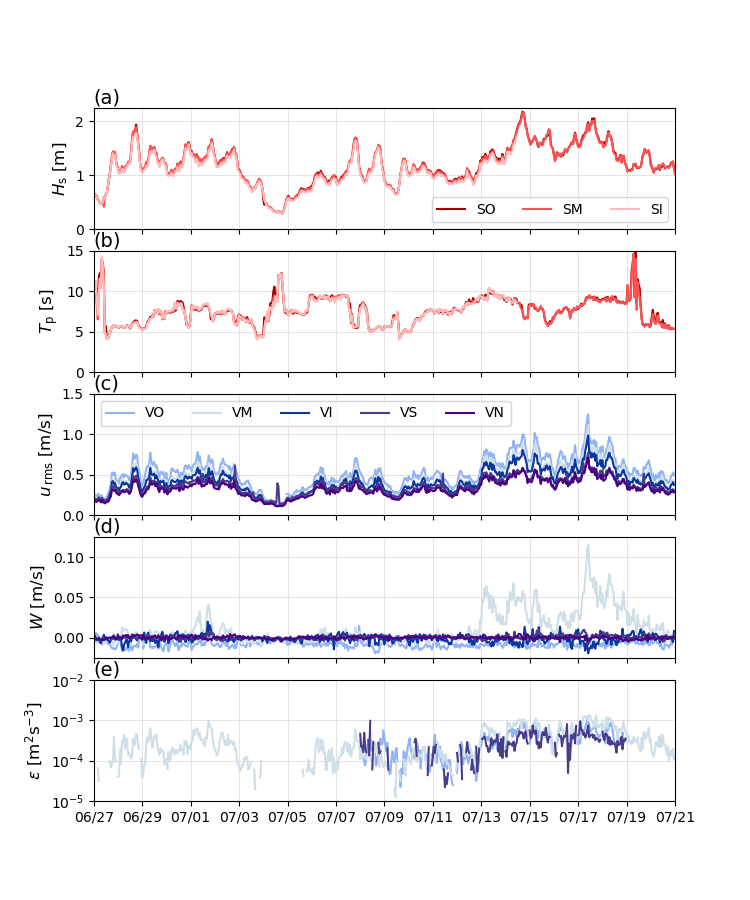

In [256]:
# Sig100 serial number to visualize
serss = ['103088', '103094', '103110',]# '103063', '103206']
midss = ['C1', 'C3', 'C6',]# 'L1', 'L5'] # Mooring IDs
sig_mids = ['SO', 'SM', 'SI'] # Signature mooring IDs to use in paper
# Use all available serial numbers
spec_key = 'ASTd' # Spectrum heave product
# Save mean datasets in dict
dsds = {} # Spectrum datasets
for ser, mid in zip(serss, midss):
    print('Reading {}-{} netcdf files ...'.format(ser, mid))
    # Get current serial number's spectrum directories
    specdir = os.path.join(sig_root, '{}'.format(ser), 'Spectra') 
    # Get spectrum netcdf file
    fn_nc_spec = os.path.join(specdir, 
                              'Asilomar_2022_SSA_Signature_{}_spec_AST.nc'.format(
                                  ser))
    dss = xr.decode_cf(xr.open_dataset(fn_nc_spec, decode_coords='all'))
    dsds[mid] = dss # Save in dict

# Get Vector Urms and mean w
midsv = ['C2', 'C3', 'C5', 'L1', 'L5']
sersv = ['17212', '17219', '17372', '6338', '6308']
vec_mids = ['VO', 'VM', 'VI', 'VS', 'VN'] # Vector mooring IDs to use in paper
date_range = pd.date_range(t0, t1, freq='1D')
dfv_dict = {} # Dict for Vector Urms/mean(w) dataframes 
# Main loop to iterate over dates and desired moorings
for mid, ser in zip(midsv, sersv):
    print(f'Getting {mid} Vec Urms...')
    # Check if dataframe already saved to csv
    fn_urms_csv = os.path.join(vec_root, 'Urms_csv', f'{mid}_urms.csv')
    if os.path.isfile(fn_urms_csv):
        dfi = pd.read_csv(fn_urms_csv, parse_dates=['time']).set_index('time')
    else:
        # Initialize pd.DataFrame for Urms, mean(w) and dissipation rate (phase res.)
        index = pd.date_range(t0, t1, freq='1H')
        dfi = pd.DataFrame(data={'Urms':np.ones_like(index).astype(float)*np.nan, 
                                'wm':np.ones_like(index).astype(float)*np.nan,
                                'eps_ps':np.ones_like(index).astype(float)*np.nan,
                                },
                        index=index)
        # Rename time index
        dfi.index = dfi.index.rename('time')
        for date in date_range:
            # Read Vector netcdf file
            ncdir = os.path.join(vec_root, mid)
            fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
                str(date.strftime('%Y%m%d'))))
            dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))

            # Iterate over bursts
            hour_range = pd.date_range(date, date+pd.Timedelta(days=1), freq='1H')
            for t0b in hour_range[:-1]:
                t1b = t0b + pd.Timedelta(hours=1)
                if t1b > t1:
                    continue
                # Select sample period
                seg = dsv.sel(time=slice(t0b, t1b))
                # Check for fraction of spikes in Vector burst
                spikes_frac_x = np.sum(~np.isclose(seg.ux, seg.uxd)) / len(seg.uz)
                spikes_frac_y = np.sum(~np.isclose(seg.uy, seg.uyd)) / len(seg.uz)
                spikes_frac_z = np.sum(~np.isclose(seg.uz, seg.uzd)) / len(seg.uz)
                # Max fraction of spikes = 0.2
                if spikes_frac_x>0.2 or spikes_frac_y>0.2 or spikes_frac_z>0.2:
                    continue
                # Get sea-surface elevation (K_rms transform)
                eta = seg.eta_lin_krms.copy().to_series() # Surface elevation
                # Convert velocities to cross-/alongshore
                if mid in ['L1', 'L5']:
                    # x vel, despiked
                    uxd = seg.uxd.to_dataframe() # Convert to pandas
                    uxd = uxd.interpolate(method='bfill').interpolate('ffill')
                    uxm = uxd.mean().item()
                    # uxd -= uxm
                    # y vel, despiked
                    uyd = seg.uyd.to_dataframe() # Convert to pandas
                    uyd = uyd.interpolate(method='bfill').interpolate('ffill')
                    uym = uyd.mean().item()
                    # uyd -= uym
                    # z vel, despiked
                    uzd = seg.uzd.to_dataframe() # Convert to pandas
                    uzd = uzd.interpolate(method='bfill').interpolate('ffill')
                    # uzd -= uzd.mean()
                    # Rotate velocities to cross/alongshore & vertical using PCA
                    ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                                        uy=uyd.values.squeeze(), 
                                                        uz=uzd.values.squeeze(),
                                                        # print_msg=True,
                                                        )
                else:
                    # Convert E,N velocities to local cross- & alongshore 
                    uE = seg.uE.to_dataframe() # Convert to pandas
                    uE = uE.interpolate(method='bfill').interpolate('ffill')
                    uN = seg.uN.to_dataframe() # Convert to pandas
                    uN = uN.interpolate(method='bfill').interpolate('ffill')
                    uU = seg.uU.to_dataframe() # Convert to pandas
                    uU = uU.interpolate(method='bfill').interpolate('ffill')
                    dss_seg = rpws.spec_uvz(z=eta.values, 
                                            u=uE.values.squeeze(), 
                                            v=uN.values.squeeze(), 
                                            fs=16,
                                            fmerge=5,
                                            )
                    # Convert to cross-alongshore based on mean wave direction
                    angle_met = dss_seg.mdir.item() # Cross-shore angle
                    angle_math = 270 - angle_met # Math angle to rotate
                    if angle_math < 0:
                        angle_math += 360
                    angle_math = np.deg2rad(angle_math) # Radians
                    # Rotate East and North velocities to cross-shore (cs) and 
                    # long-shore (ls)
                    ucs, uls = rpct.rotate_vel(uE.values.squeeze(), 
                                            uN.values.squeeze(), 
                                            angle_math,
                                            )
                    uw = uU.values.squeeze() # Vertical vel.
                # Estimate U-rms for burst
                uspec = rpws.spec_uvz(ucs, fs=16, fmerge=5)
                vspec = rpws.spec_uvz(uls, fs=16, fmerge=5)
                # Variance of cross- and alongshore orbital velocities
                m0u = rpws.spec_moment(uspec.Ezz.values, uspec.freq.values, 0)
                m0v = rpws.spec_moment(vspec.Ezz.values, vspec.freq.values, 0)
                Urms = np.sqrt(2 * (m0u + m0v))
                wm = np.nanmean(uw)
                # Populate dataframe
                dfi['Urms'].loc[t0b] = Urms
                dfi['wm'].loc[t0b] = wm

            # Read daily dissipation rate files
            csvdir = os.path.join(ncdir, 'dissipation_rate')
            if not os.path.isdir(csvdir):
                os.mkdir(csvdir)
            fn_csv_diss = os.path.join(csvdir, 
                                       'burst_diss_{}_{}_nhours_24.csv'.format(
                                           mid, date.strftime('%Y%m%d_%H%M')))
            if os.path.isfile(fn_csv_diss):
                # Read daily dissipation rate file
                dfeps = pd.read_csv(fn_csv_diss, parse_dates=['time']).set_index(
                    'time')
                # Populate dataframe
                for t0b in hour_range[:-1]:
                    dfi['eps_ps'].loc[t0b] = dfeps['eps_phase'].loc[t0b]

        # Save complete dataframe to csv
        dfi.to_csv(fn_urms_csv)
    # Add complete dataframe to dict
    dfv_dict[mid] = dfi

# Plot time series
fontsize = 12
fig, axes = plt.subplots(figsize=(7.5,9), nrows=5, sharex=True, )
                         # constrained_layout=True,)
# Twin axes for top two rows
# axt0 = axes[0].twinx()
# axt1 = axes[1].twinx()
# lss = ['-', '--', ':', '-.', '-'] # Linestyles
lss = ['-', '-', '-'] # Linestyles
clss = ['#a70000', '#ff5252', '#ffbaba'] # Signature colors
# Vector colors
clsv = ['#92B4F4', '#CFDEE7', '#0A369D', 'darkslateblue', 'indigo'] 
# C6 Signature started wobbling after approx. 14 July 11:00
t1_c6 = pd.Timestamp('2022-07-14 11:00')
# Sea level variation on twin axis
# dsds['C1'].msl_dev_ast.sel(time=slice(t0,t1)).plot(ax=axt0, color='lightgray', 
#                                               alpha=0.5, lw=3)
# axt0.set_ylim([-1.5, 1.5])
# axt0.set_ylabel(r'$\overline{\eta}$ [m]', fontsize=fontsize)
# for i, (mid, ser) in enumerate(zip([mids[1]], [sers[1]])):

# Signature wave variables on top 2 rows
for i, (mid, ser) in enumerate(zip(midss, serss)):
    # Hs on top
    if not mid=='C6':
        dsds[mid].Hm0.sel(time=slice(t0,t1)).plot(ax=axes[0], color=clss[i], 
                                                  linestyle=lss[i], 
                                                  label=sig_mids[i],
                                                  )
    else:
        # C6 started wobbling after approx. 14 July 11:00
        dsds[mid].Hm0.sel(time=slice(t0,t1_c6)).plot(ax=axes[0], color=clss[i], 
                                                     linestyle=lss[i], 
                                                     label=sig_mids[i])
    axes[0].set_ylabel(r'$H_\mathrm{s}$ [m]', fontsize=fontsize)
    # Tp on second row
    if not mid=='C6':
        dsds[mid].Tp_Y95.sel(time=slice(t0,t1)).plot(ax=axes[1], color=clss[i], 
                                                     linestyle=lss[i], 
                                                     label=sig_mids[i])
    else:
        dsds[mid].Tp_Y95.sel(time=slice(t0,t1_c6)).plot(ax=axes[1], color=clss[i], 
                                                        linestyle=lss[i], 
                                                        label=sig_mids[i])
    axes[1].set_ylabel(r'$T_\mathrm{p}$ [s]', fontsize=fontsize)

# Vector velocity time series on remaining rows
for i, (mid, ser) in enumerate(zip(midsv, sersv)):
    # Urms on 3rd row
    axes[2].plot(dfv_dict[mid].index, dfv_dict[mid]['Urms'], label=vec_mids[i],
                 color=clsv[i])
    axes[2].set_ylabel(r'$u_\mathrm{\, rms}$ [m/s]', fontsize=fontsize)
    # mean(w) on 4th row
    axes[3].plot(dfv_dict[mid].index, dfv_dict[mid]['wm'], label=vec_mids[i],
                 color=clsv[i])
    axes[3].set_ylabel(r'$W$ [m/s]', fontsize=fontsize)
    # dissipation rate on 5th row
    axes[4].plot(dfv_dict[mid].index, dfv_dict[mid]['eps_ps'], label=vec_mids[i],
                 color=clsv[i])
    axes[4].set_ylabel(r'$\epsilon$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$', 
                       fontsize=fontsize)
    # Log y scale
    axes[4].set_yscale('log')

ann = ['(a)', '(b)', '(c)', '(d)', '(e)'] 
for i,ax in enumerate(axes):
    ax.set_xlabel(None)
    # Remove empty space from x axis
    ax.margins(x=0)
    ax.grid(alpha=0.5, lw=0.5)
    # Annotate (a), (b), ...
    ax.annotate(ann[i], xy=(0.0, 1.035), xycoords='axes fraction', fontsize=14)

# Signature legend
axes[0].legend(ncol=3, loc='lower right')
# Vector legend
axes[2].legend(ncol=5, loc='upper left')

# Limits
axes[0].set_ylim([0, 2.25])
axes[1].set_ylim([0, 15])
axes[2].set_ylim([0, 1.5])
axes[3].set_ylim([-0.025, 0.125])
axes[4].set_ylim([1e-5, 1e-2])
axes[4].set_yticks([1e-5, 1e-4, 1e-3, 1e-2])

# Format x (time) axis
date_axis = pd.date_range(t0, t1, freq='2D')
axes[-1].set_xticks(date_axis)
# Rotate date ticks
# axes[-1].set_xticklabels(date_axis, rotation=30, ha='center')
# Set date format
myFmt = mdates.DateFormatter('%m/%d')
axes[-1].xaxis.set_major_formatter(myFmt)
# axes[0].margins(x=0)

plt.subplots_adjust(wspace=0.0, hspace=0.18)
# plt.tight_layout()
plt.show()

Figure 3: Example methods figure of phase resolved wave heights, orbital velocities and dissipation rate.

Main loop ...
C3 - 17219


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)


L1 - 6338
MDIR: 269.95


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/turbulence.py:130: RuntimeWarning: invalid value encountered in log
  return np.log(c) + (-5/3) * np.log(x)


MDIR: 270.26
MDIR: 269.24
Concatenating wave elevation and velocity dataframes ...


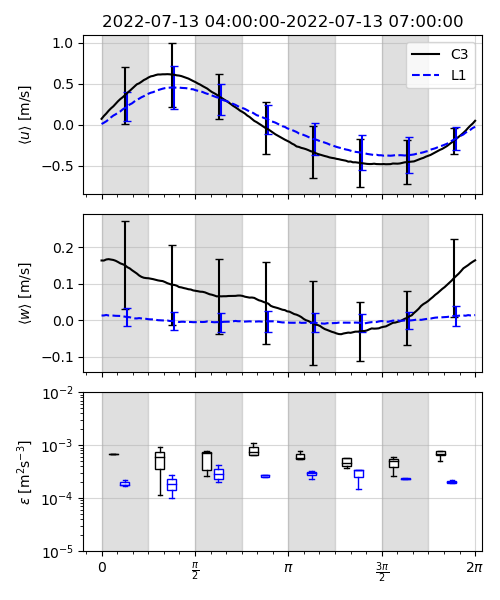

In [269]:
mids = [ 'C3', 'L1']
sers = ['17219', '6338']
fs = 16 # Sampling freq
# Define number of sub-segments per wave cycle (should be even)
ncyc = 8
# Minimum R^2 threshold for inertial subrange fits
r2_thresh = 0.9
# Minimum ratio of eddy timescale over advection timescale
eddy_adv_ratio = 5
# Sample period
t0 = pd.Timestamp('2022-07-13 04:00:00')
nhours = 3 # No. of hours to process at once
t1 = t0 + pd.Timedelta(hours=nhours)
spd = 60 * 60 * 24 # Seconds per day
# Define expected headings in PCA coordinates for C2, C3 & C4
heading_exp_1 = {'C2': -125, 'C3': -90, 'C4': -90, 'L2': None, 'L1': 160, 'L5':None}
# After 2022-07-13 04:00 (C4)
heading_exp_2 = {'C2': -125, 'C3': -90, 'C4': -20, 'L2': None, 'L1': 160, 'L5':None}

# Lists for hourly burst averages
wave_int_e = {'{}'.format(m): [] for m in mids} # Interpolated wave elevations
wave_int_u = {'{}'.format(m): [] for m in mids} # Interpolated wave u velocities
wave_int_v = {'{}'.format(m): [] for m in mids} # Interpolated wave v velocities
wave_int_w = {'{}'.format(m): [] for m in mids} # Interpolated wave w velocities
eps_lt83 = {'{}'.format(m): [] for m in mids}
# Dataframes for burst-average dissipation and U_rms
time_range = pd.date_range(t0, t1, freq='1H') # Time index
nt = len(time_range)
dfbd = {'{}'.format(m): pd.DataFrame(data={'eps_phase': np.ones(nt)*np.nan, 
                                           'eps_phase_std': np.ones(nt)*np.nan,
                                           'eps_LT83': np.ones(nt)*np.nan,
                                           'U_rms': np.ones(nt)*np.nan,
                                           'depth': np.ones(nt)*np.nan,
                                           },
                                     index=time_range) for m in mids
        }
# Dissipation rates per wave-cycle subsegment
diss_subseg = {'{}'.format(m): {} for m in mids}
U_subseg = {'{}'.format(m): {} for m in mids}
for mid in mids:
    diss_subseg[mid] = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}
    U_subseg[mid] = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}
# Wave-by-wave dissipation rates lists for concatenating dataframes
dfw_list = {'{}'.format(m): [] for m in mids}

# Lists for histograms
udu_ratios = {} # U/dU ratios
t_ratios = {} # eddy/adv time scale ratios
for mid in mids:
    udu_ratios[mid] = []
    t_ratios[mid] = []
# List for timestamps of bursts to skip due to too many spikes
skip_list = []

# Define type of fit to use for dissipation rate calculation
fit = 'linear'
# Define number of bins to use for advection speed U (1-4)
nbins = 4
if nbins == 2:
    # Define U ranges for 2 bins
    ubins = [(0, 0.5), (0.5, 2)]
elif nbins == 3:
    # Define U ranges for 3 bins
    ubins = [(0, 0.25), (0.25, 0.5), (0.5, 2)]
elif nbins == 4:
    # Define U ranges for 4 bins
    ubins = [(0, 0.15), (0.15, 0.3), (0.3, 0.45), (0.45, 2)]

# Main loop to iterate over desired moorings
print('Main loop ...')
for mid, ser in zip(mids, sers):
    print('{} - {}'.format(mid, ser))
    # Read netcdf file, check if need to concatenate multiple days
    if ((t1.date() - t0.date()).total_seconds() / spd) > 0:
        # More than one day -> concatenate daily datasets
        drc = pd.date_range(t0.date(), t1.date(), freq='1D') # Range of dates
        dlc = [] # List for concatenating
        for d in drc:
            ncdir = os.path.join(vec_root, mid)
            fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(
                ser, str(d.strftime('%Y%m%d'))))
            dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
            # Append to list
            dlc.append(dsv)
        # Concatenate daily datasets
        dsv = xr.concat(dlc, dim='time')
    else:
        # Only one day
        ncdir = os.path.join(vec_root, mid)
        fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
            str(t0.strftime('%Y%m%d'))))
        dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
    # Wave counter
    wcnt = 0
    # Iterate over bursts
    for t0b in time_range:
        t1b = t0b + pd.Timedelta(hours=1)
        if t1b > t1:
            continue
        # Select sample period
        seg = dsv.sel(time=slice(t0b, t1b))
        # Get sea-surface elevation (K_rms transform)
        eta = seg.eta_lin_krms.copy().to_series() # Surface elevation
        # Convert velocities to cross-/alongshore
        if mid in ['L1', 'L5', 'C1', 'C6']:
            # x vel, despiked
            uxd = seg.uxd.to_dataframe() # Convert to pandas
            uxd = uxd.interpolate(method='bfill').interpolate('ffill')
            uxm = uxd.mean().item()
            uxd -= uxm
            # y vel, despiked
            uyd = seg.uyd.to_dataframe() # Convert to pandas
            uyd = uyd.interpolate(method='bfill').interpolate('ffill')
            uym = uyd.mean().item()
            uyd -= uym
            # z vel, despiked
            uzd = seg.uzd.to_dataframe() # Convert to pandas
            uzd = uzd.interpolate(method='bfill').interpolate('ffill')
            uzd -= uzd.mean()
            # Get correct expected heading for C4
            if t0b <= pd.Timestamp('2022-07-13 04:00'):
                he = heading_exp_1[mid]
            else:
                he = heading_exp_2[mid]
            # Rotate velocities to cross/alongshore & vertical using PCA
            ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                                uy=uyd.values.squeeze(), 
                                                uz=uzd.values.squeeze(),
                                                heading_exp=he, 
                                                # print_msg=True,
                                                )
            # Check if mean wave direction is 270
            dssu = rpws.spec_uvz(z=eta.values, u=ucs, v=uls, fs=16, fmerge=5)
            # If mdir close to 90 deg -> flip velocities
            if abs(dssu.mdir.item() - 270) > 90:
                ucs *= (-1)
                uls *= (-1)
                uw *= (-1)
            dssu = rpws.spec_uvz(z=eta.values, u=ucs, v=uls, fs=16, fmerge=5)
            print('MDIR: {:.2f}'.format(dssu.mdir.item()))
        else:
            # Convert E,N velocities to local cross- & alongshore (x,y) components
            uE = seg.uE.to_dataframe() # Convert to pandas
            uE = uE.interpolate(method='bfill').interpolate('ffill')
            uN = seg.uN.to_dataframe() # Convert to pandas
            uN = uN.interpolate(method='bfill').interpolate('ffill')
            uU = seg.uU.to_dataframe() # Convert to pandas
            uU = uU.interpolate(method='bfill').interpolate('ffill')
            dss_seg = rpws.spec_uvz(z=eta.values, 
                                    u=uE.values.squeeze(), 
                                    v=uN.values.squeeze(), 
                                    fs=16,
                                    )
            # Rotate according to mean wave direction
            angle_met = dss_seg.mdir.item() # Cross-shore angle
            angle_math = 270 - angle_met # Math angle to rotate
            if angle_math < 0:
                angle_math += 360
            angle_math = np.deg2rad(angle_math) # Radians
            # Rotate East and North velocities to cross-shore (cs) and 
            # long-shore (ls)
            ucs, uls = rpct.rotate_vel(uE.values.squeeze(), 
                                        uN.values.squeeze(), 
                                        angle_math,
                                        )
            uw = uU.values.squeeze() # Vertical vel.
        # Estimate U-rms for burst
        uspec = rpws.spec_uvz(ucs, fs=16, fmerge=5)
        vspec = rpws.spec_uvz(uls, fs=16, fmerge=5)
        # Variance of cross- and alongshore orbital velocities
        m0u = rpws.spec_moment(uspec.Ezz.values, uspec.freq.values, 0)
        m0v = rpws.spec_moment(vspec.Ezz.values, vspec.freq.values, 0)
        Urms = np.sqrt(2 * (m0u + m0v))
        # Mean current
        Uburst = np.sqrt(ucs.mean().item()**2 + uls.mean().item()**2)
        # Mean depth
        h = seg.z_hyd.mean().item()
        # Estimate full w-spectrum (testing)
        wspec = rpws.spec_uvz(uw, fs=16, fmerge=5)

        # Estimate full burst dissipation rate following 
        # Lumley & Terray (1983) and Trowbridge & Elgar (2001)
        eps, r2, cf = rpt.dissipation_rate_LT83(f=wspec.freq.values.squeeze(),
                                                spec=wspec.Ezz.values.squeeze(),
                                                U=Uburst, sigma=np.sqrt(m0u+m0v),
                                                skip_f=10)
        eps_lt83[mid].append(eps)
        dfbd[mid]['eps_LT83'].loc[t0b] = eps

        # Get zero-crossings, min. 4-sec waves
        zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='up', minlen=4*16)
        nwaves = len(Hw)
        # Compute H(1/3)
        Hws = np.sort(Hw) # Sorted wave heights
        H13 = np.mean(Hws[2*(nwaves//3):]) # Mean of highest 1/3 of waves
        # Define phase (x) axis to interpolate to
        n_phase = 160 # Number of points in phase axis
        min_period = 6 # Min. wave period (sec) to include

        # Lists for storing dataframes of spectral segments for merging
        # for different ranges of advection speed U
        dfsi_lists_1 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
        dfsi_lists_2 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
        dfsi_lists_3 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
        dfsi_lists_4 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
        dssi = {'q{}'.format(n): [] for n in range(1,ncyc+1)}

        # Interpolate eta, u_cs and w for each wave to wave phase (0-2*pi)
        for zi,zc0 in enumerate(zc[:-1]):
            # Only include waves with T > min_period sec
            Tw = (eta.index[zc[zi+1]] - eta.index[zc[zi]]).total_seconds()
            if Tw < min_period:
                continue
            # Also only include high waves
            Hwi = Hw[zi]
#             if Hwi < H13:
#                 continue
            # Wave surface elevation, u, v and w for current wave
            eta_wave = eta.iloc[zc0:zc[zi+1]]
            u_wave = ucs[zc0:zc[zi+1]]
            v_wave = uls[zc0:zc[zi+1]]
            w_wave = uw[zc0:zc[zi+1]]
            # Surface elevation interpolation
            df_e = rpzc.interpolate_phase(eta_wave.squeeze(), N=n_phase, 
                                            label='eta_int_{:04d}'.format(wcnt))
            wave_int_e[mid].append(df_e)
            # Cross-shore vel. interpolation
            df_u = rpzc.interpolate_phase(u_wave.squeeze(), N=n_phase, 
                                        label='u_int_{:04d}'.format(wcnt))
            wave_int_u[mid].append(df_u)
            # Long-shore vel. interpolation
            df_v = rpzc.interpolate_phase(v_wave.squeeze(), N=n_phase, 
                                        label='u_int_{:04d}'.format(wcnt))
            wave_int_v[mid].append(df_v)
            # Vertical vel. interpolation
            df_w = rpzc.interpolate_phase(w_wave.squeeze(), N=n_phase, 
                                        label='u_int_{:04d}'.format(wcnt))
            wave_int_w[mid].append(df_w)
            # Also make df of non-interpolated vert. vel. with phase axis
            phase_ni = np.linspace(0, 1, len(w_wave)) #* 2*np.pi # non-int. phases
            df_wni = pd.DataFrame(data=w_wave.squeeze(), index=phase_ni)
            # Increase wave counter
            wcnt += 1

            # Estimate spectra for 1/ncyc wave cycles
            nsub = n_phase // ncyc # no. of samples per phase sub-segment
            nsub_ni = len(phase_ni) // ncyc # non-interpolated # of samples
            # Frequencies
            n_freqs = int(np.floor(nsub / 2 )) # No. of frequency bands
            n_freqs_ni = int(np.floor(nsub_ni / 2 )) # No. of frequency bands
            # Wavenumbers to interpolate spectrum to
            n_int = 30 # Number of wavenumbers to interpolate to
            kmin = (2*np.pi) / 0.5 # Min. interpolation wavenumber
            kmax = (2*np.pi) / 0.05 # Max. interpolation wavenumber
            ki = np.linspace(kmin, kmax, n_int) # Interp. target k's
            # Initialize dict to store spectral dataframes (incl. U)
            dfsi = {} # k-spec dataframes
            for nb in range(1, nbins+1):
                dfsi['{}'.format(nb)] = {}
            for i in range(ncyc):
                # Get short-segment interpolated velocities
                useg = df_u.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                vseg = df_v.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                wseg = df_w.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                # Also get non-interpolated vertical velocity segment
                wseg_ni = df_wni.iloc[i*nsub_ni:(i+1)*nsub_ni].values.squeeze()
                # Timestamp
                t0seg = (pd.Timestamp(eta_wave.index[0]) + 
                            pd.Timedelta(seconds=(Tw/n_int)*(i/ncyc)))
                # Compute mean current and check that U >> dU for segment
                U = np.sqrt(np.mean(useg)**2 + np.mean(vseg)**2).item() # Mean orb. vel. mag.
                umag = np.sqrt(useg**2 + vseg**2) # Orb. vel. magnitude, not mean
                dU = np.std(umag) # Variability in umag (following George et al., 1994)
                # Append U / dU ratio to list for histogram
                udu_ratios[mid].append(U / dU)
                # Check U/dU ratio
                if (U / dU) < 1:
                    # U vs. dU ratio (Eq (6) of George et al., 1994) too small
                    # Use U / dU = 1 as threshold following Rosman & Gerbi (2017), 
                    # Fig. 9
                    continue
                # Check that the turnover timescale of the eddies is much longer 
                # than the time for advection of the eddies past the sensor.
                # First estimate k spectrum of w following George et al. (1994)
                dsk_i = rpt.k_spec_wavephase(w=wseg_ni, U=U)
                # Check highest allowable k based on sampling rate and volume
                maxk_check = np.min((kmax, np.pi*fs/U))
                # Set to NaN all spectral elements with k > maxk
                dsk_i.k_spec.values = dsk_i.k_spec.where(dsk_i.k < maxk_check).values
                # Make (noisy) first estimate of dissipation rate from single
                # spectrum for eddy time scale
                rs_list = [] # R^2 values of fits
                eps_list = [] # Dissipation rate estimates from fits
                si_list = [] # Start indices of fits (to get lowest k of best fit)
                sis = np.arange(1, n_freqs_ni//2) # Start indices of -5/3 fit
                eis = -np.arange(1, n_freqs_ni//2)[::-1] # End indices of fit
                # Iterate over different k ranges and fit inertial subrange
                for si in sis:
                    for ei in eis:
                        N = len(dsk_i.k.values[si:ei])
                        if N < n_freqs_ni // 2:
                            # Don't try to fit to less than half of 
                            # available points
                            continue
                        elif N < 5:
                            # Don't fit to less than 5 data points
                            continue
                        # No NaNs allowed
                        if np.any(np.isnan(dsk_i.k_spec.values.squeeze()[si:ei])):
                            continue
                        # Get diss. rate and R^2 of inertial subrange fit to 
                        # spectrum segment
                        epsilon, r_squared, coeff = rpt.dissipation_rate(
                            k=dsk_i.k.values[si:ei], 
                            spec=dsk_i.k_spec.values.squeeze()[si:ei], 
                            fit=fit)
                        # Save R^2 and epsilon to dict
                        rs_list.append(r_squared)
                        eps_list.append(epsilon)
                        si_list.append(si)
                # Find best fit from R^2 (highest) and fit length (longest)
                if len(rs_list) == 0:
                    # No fits were made (too many NaNs)
                    continue
                # Get index of max. R^2
                max_rsq_ind = np.argmax(rs_list)
                # Use dissipation rate estimate with highest R^2 value
                eps_est = eps_list[max_rsq_ind]
                # Use lowest k included in the best fit
                sim = si_list[max_rsq_ind]
                l = 2*np.pi / dsk_i.k.values[sim]
                # Compute eddy time scale (Eq. 6.11 of Pope, pg. 187)
                t_eddy = (l**2 / eps_est)**(1/3)
                # Compute advection time scale
                t_adv = l / U
                t_ratios[mid].append(t_eddy / t_adv)
                # Check t_eddy vs. t_adv criterion, only save spectrum
                # for later ensemble averaging if ratio high enough
                if (t_eddy / t_adv) < eddy_adv_ratio:
                    # Ratio too low -> don't save spectrum
                    continue
                # Estimate new k-spectrum and interpolate to pre-defined k axis
                dsk = rpt.k_spec_wavephase(w=wseg_ni, U=U, k_int=ki)
                # Add wave height and wave counter as variable
                dsk['Hw'] = ([], Hwi)
                dsk['wcnt'] = ([], wcnt)
                # Add time coordinate to spectrum dataset
                dsk = dsk.assign_coords(time=[t0seg])
                # Check highest allowable k
                maxk = np.min((2*np.pi/0.05, np.pi*fs/U))
                # Set to NaN all spectral elements with k > maxk
                dsk.k_spec.values = dsk.k_spec.where(dsk.k < maxk).values
                # Append to list
                dssi['q{}'.format(i+1)].append(dsk)

        # Concatenate spectral datasets
        dss = {} # Datasets to concatenate
        for n in range(1, ncyc+1):
            if len(dssi['q{}'.format(n)]) > 0:
                dss['q{}'.format(n)] = xr.concat(
                        dssi['q{}'.format(n)], dim='time')

        # Dicts to store curve fit coeff.
        rsqs = {} # R^2 value for best fit
        coeffs = {} # Fit coefficient for best fit
        sid = {} # Optimal start index for fit
        eid = {} # Optimal end index for fit
        diss_rate = {}
        U_diss = {}

        # Iterate over sub-sections
        for n in range(1, ncyc+1):
            # Iterate over U ranges defined by nbins
            for ui in range(nbins):
                # Select correct dataset
                if f'q{n}' in dss.keys():
                    dsi = dss['q{}'.format(n)].copy()
                    # Select correct U range if using more than 1 U bin
                    if nbins > 1:
#                         dsi = dsi.where(
#                             np.logical_and(dsi.U>=ubins[ui][0], dsi.U<ubins[ui][1]), 
#                             drop=True,
#                             )
                        dsi = dsi.isel(
                            time=np.logical_and(
                                dsi.U>=ubins[ui][0], dsi.U<ubins[ui][1]))
                        # Check that the selected U range has data
                        if len(dsi.time) == 0:
                            continue
                    # Average spectra for wavenumbers with no more than maxnan 
                    # fraction of NaN values
                    maxnan = 0.2 # Max. allowed fraction of NaNs per wavenumber
                    good_inds = (dsi.k_spec.isnull().sum(dim='time')/len(dsi.time)<=maxnan)
                    ps_mean = dsi.where(good_inds).mean(dim='time').k_spec.values
                    # Also get corresponding U values
                    U_mean = dsi.where(good_inds).U.mean(dim=['k', 'time']).item()
                    # Lists to store curve fit coeff.
                    rsqs_i = [] # R^2 value for best fit
                    coeffs_i = [] # R^2 value for best fit
                    sid_i = [] # Optimal start index for fit
                    eid_i = [] # Optimal end index for fit
                    npts = [] # Number of points to fit
                    diss_i = [] # Dissipation rates
                    U_i = [] # rms velocities
                    # Iterate over different start/end freq. indices for fit
                    # Disregard first (0-th) wavenumber
                    sis = np.arange(1, n_int//2) # Start indices of fits
                    eis = -np.arange(1, n_int//2)[::-1] # End inds of fits
                    for si in sis:
                        for ei in eis:
                            N = len(ki[si:ei])
                            if N < n_int // 2:
                                # Don't try to fit to less than half of 
                                # available points
                                continue
                            # No NaNs allowed
                            if np.any(np.isnan(ps_mean[si:ei])):
                                continue
                            # Get diss. rate and R^2 of inertial subrange fit to 
                            # spectrum segment
                            epsilon, r_squared, coeff = rpt.dissipation_rate(
                                k=ki[si:ei], spec=ps_mean[si:ei], fit=fit)
                            # Save to dict if R^2 high enough
                            if r_squared >= r2_thresh:
                                rsqs_i.append(r_squared)
                                coeffs_i.append(coeff)
                                diss_i.append(epsilon)
                                sid_i.append(si)
                                eid_i.append(ei)
                                npts.append(N)
                                U_i.append(U_mean)
                    # Find best fit from R^2 (highest) and fit length (longest)
                    if len(rsqs_i) == 0:
                        # No fits were made (too many NaNs)
                        continue
                    max_rsq_ind = np.argmax(rsqs_i)
                    # Save parameters corresponding to max R^2
                    diss_rate['q{}'.format(n)] = diss_i[max_rsq_ind]
                    rsqs['q{}'.format(n)] = rsqs_i[max_rsq_ind]
                    coeffs['q{}'.format(n)] = coeffs_i[max_rsq_ind]
                    U_diss['q{}'.format(n)] = U_i[max_rsq_ind]
                    sid['q{}'.format(n)] = sid_i[max_rsq_ind]
                    eid['q{}'.format(n)] = eid_i[max_rsq_ind]
                    # Also append to ensemble-avg list
                    diss_subseg[mid]['{}/{}'.format(n, ncyc)].append(
                        diss_i[max_rsq_ind])
                    U_subseg[mid]['{}/{}'.format(n, ncyc)].append(
                        U_i[max_rsq_ind])
                else:
                    # Data not good enough for any dissipation rate estimates
                    diss_rate['q{}'.format(n)] = np.nan
                    rsqs['q{}'.format(n)] = np.nan
                    coeffs['q{}'.format(n)] = np.nan
                    U_diss['q{}'.format(n)] = np.nan
                    # Also append to ensemble-avg list
                    diss_subseg[mid]['{}/{}'.format(n, ncyc)].append(np.nan)
                    U_subseg[mid]['{}/{}'.format(n, ncyc)].append(np.nan)

        # Save burst-average dissipation and U_rms
        dfbd[mid]['eps_phase'].loc[t0b] = np.array(list(diss_rate.values())).mean()
        dfbd[mid]['eps_phase_std'].loc[t0b] = np.array(list(
            diss_rate.values())).std()
        dfbd[mid]['U_rms'].loc[t0b] = Urms
        dfbd[mid]['depth'].loc[t0b] = h

# Average wave phase vs. dissipation rate plot
cs = ['k', 'b', 'r']
lss = ['-', '--', ':']
fn_fig3 = os.path.join(outdir, 'fig3__{}_{}.pdf'.format(
        ''.join(mids), t0.strftime('%Y%m%d_%H%M')))
if not os.path.isfile(fn_fig3):
    # Concatenate interpolated wave variables dataframes
    # df_ei = {'{}'.format(m): [] for m in mids}
    df_ei = {}
    df_ui = {}
    df_vi = {}
    df_wi = {}
    print('Concatenating wave elevation and velocity dataframes ...')
    for mid in mids:
        df_ei[mid] = pd.concat(wave_int_e[mid], axis=1) # Interp. surf. elev.
        df_ui[mid] = pd.concat(wave_int_u[mid], axis=1) # Interp. cs vel.
        df_vi[mid] = pd.concat(wave_int_v[mid], axis=1) # Interp. ls vel.
        df_wi[mid] = pd.concat(wave_int_w[mid], axis=1) # Interp. vertical vel.
    fig, axes = plt.subplots(figsize=(5,6), nrows=3, sharex=True)
    for ax in axes:
        # Mark subsections
        for nc in np.arange(ncyc)[::2]:
            ax.axvspan(nc*2*np.pi/ncyc, (nc+1)*2*np.pi/ncyc, color='gray', 
                       alpha=0.25)
    # Iterate over moorings
    for m, mid in enumerate(mids):
        # Ensemble-avg eta on top, with +/- 1*std errorbars
        axes[0].errorbar(df_ui[mid].index, df_ui[mid].mean(axis=1), 
            ls=lss[m], yerr=df_ui[mid].std(axis=1), c=cs[m], capsize=3, 
            errorevery=((m+10),20), label=mid)
        # Ensemble-avg w in middle, with +/- 1*std errorbars
        axes[1].errorbar(df_wi[mid].index, df_wi[mid].mean(axis=1), 
            ls=lss[m], yerr=df_wi[mid].std(axis=1), c=cs[m], capsize=3, 
            errorevery=((m+10),20))
        # Dissipation rates per wave-phase subsection
        for n in range(1, ncyc+1):
            # All epsilon values for current phase subsection
            eps = diss_subseg[mid]['{}/{}'.format(n, ncyc)]
            # Centered x-locations
            position = [n*2*np.pi/ncyc - np.pi/(ncyc) - (np.pi/16)*(2-(m+1))]
            # Box plot of epsilon range
            # axes[2].boxplot(x=eps, positions=positions, color=cs[m])
            rppl.box_plot(ax=axes[2], data=eps, positions=position, 
                edge_color=cs[m], fill_color='white', showfliers=False)

    # Set x axis labels as multiples of pi
    for ax in axes:
        ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(rppl.multiple_formatter()))
        # Grid
        ax.grid(alpha=0.5)

    # Axis labels
    axes[0].set_title('{}-{}'.format(t0, t1))
    # axes[0].set_ylabel(r'$\langle \zeta \rangle$ [m]')
    axes[0].set_ylabel(r'$\langle u \rangle$ [m/s]')
    axes[1].set_ylabel(r'$\langle w \rangle$ [m/s]')
    axes[2].set_ylabel(r'$\epsilon$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$')

    # Legend on top row
    handles, labels = axes[0].get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # use them in the legend
    axes[0].legend(handles, labels, loc='upper right')

    # Set dissipation rate y scale to log
    axes[2].set_yscale('log')
    axes[2].set_ylim([1e-5, 1e-2])

    plt.tight_layout()
    plt.show()
    # plt.savefig(fn_fig3, bbox_inches='tight', dpi=450)
    # plt.close()
